In [1]:
#loading packages
library(rvest)
library(tidyverse)
library(dplyr)
library(ggplot2)
library(magrittr) 
library(purrr) 
library(glue)
library(stringr) 
library(httr)
library(jsonlite)
library(gapminder)
library(readxl)
library(lubridate)
library(visdat)
library(writexl)
library(visdat)
library(sf) # working with geographic simple features in R
library(rnaturalearth) # World map data from Natural Earth
library(countrycode) # get ISO code from country names
library(ggrepel) # "ggplot2" extension for overlapping text labels

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.2     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.3     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.1     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter()         masks stats::filter()
✖ readr::guess_encoding() masks rvest::guess_encoding()
✖ dplyr::lag()            masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: 'magrittr'


The following object is masked from 'package:purrr':

    set_names


The following object is masked from 'package:tidyr':

    extract



Attaching package: 'jsonlite'


The following object is masked from 'package:purrr':

    flatten


Linking to GEOS 3.11.2, GDAL 3.6.2, PROJ 9.2.0; sf_use_s2() is TRUE

The legacy packages maptools, rgdal, and rgeos, underpinning th

Bringing in the data that is locally stored

In [2]:
df_free = read_excel('polrights_fh.xlsx') #new dataset
df_bmi = read_csv('bmi_data.csv', show_col_types = FALSE) #original dataset
df_gini = read_csv('ddf--datapoints--gapminder_gini--by--geo--time.csv', show_col_types = FALSE)
df_gdp = read_csv('gdppercapita_us_inflation_adjusted.csv', show_col_types = FALSE) #original dataset
df_sugar = read_csv('sugar_per_person_g_per_day.csv', show_col_types = FALSE)

*add some shit doing the summary stats - or check the group*

bringing in country info from github

In [3]:
country_codes = fromJSON('https://gist.githubusercontent.com/bensquire/1ba2037079b69e38bb0d6aea4c4a0229/raw/8609a1a86683bbd6d0e4a7e9456eabf6e7b65b7f/countries.json')

df_countries = as.data.frame(country_codes) %>%
    mutate(country_code = code,
           country = name) %>%
    select(country_code, country, eu)

Pivoting and filtering data

In [4]:
#the gini coefficient data 
pivot_free = df_free %>%
    pivot_longer(cols = -country, names_to='year', 
                 values_to='Freedom_index')

pivot_free = pivot_free %>%
    filter(year > 1974, year < 2017) %>% #filtering to the same timespan
    mutate(Freedom_index = as.factor(Freedom_index),
          year = as.numeric(year))

In [5]:
#sugar consumption dataset 
pivot_sugar = df_sugar %>%
    pivot_longer(cols = -country, names_to='year', 
                 values_to='daily_sugar_pp_grams')

pivot_sugar = pivot_sugar %>%
    filter(year > 1974, year < 2017) %>% #filtering to the same timespan
    drop_na() %>%
    mutate(year = as.numeric(year))

In [6]:
#print(colnames(pivot_sugar))
#print(unique(df_countries$country))

In [7]:
#gdp/capita dataset
pivot_gdp = df_gdp %>%
    pivot_longer(cols = -country, names_to='year', 
                 values_to='GDP_per_capita')

pivot_gdp = pivot_gdp %>%
    filter(year > 1974, year < 2017) %>% #filtering to the same timespan
    mutate(year = as.numeric(year)) 

Now it is time to clean some data - the goal is to merge all of the data together.  

This will require changing column names and datatypes

In [8]:
#cleaning the gdp data, converting the GDP measures into the right data format
pivot_gdp <- pivot_gdp %>% 
  mutate(GDP_per_capita = as.numeric(str_replace_all(GDP_per_capita, c( '\\.' = '', 'k' = '000'))))

In [9]:
#cleaning gini dataset - rename variables, convert country_code obs to upper case
df_gini_clean = df_gini %>%
    mutate(country_code = toupper(geo),
           year = time,
           gini = gapminder_gini) %>%
    filter(year > 1974, year < 2017) %>%
    select(country_code, year, gini)

In [10]:
#going to merge on country and year. so need to rename cols
df_bmi = df_bmi %>%
    rename('country' = 'Location',
           'year' = 'Period',
            'country_code' = 'SpatialDimValueCode')

In [11]:
df_bmi$country[df_bmi$country %in% 'United States of America'] <- "United States"
pivot_free$country[pivot_free$country %in% 'USA'] <- "United States"
pivot_sugar$country[pivot_sugar$country %in% 'USA'] <- "United States"
pivot_gdp$country[pivot_gdp$country %in% 'USA'] <- "United States"




In [12]:
pivot_sugar$country[pivot_sugar$country %in% 'Bolivia'] <- "Bolivia, Plurinational State of"

pivot_sugar$country[pivot_sugar$country %in% 'UK'] <- "United Kingdom"

pivot_sugar$country[pivot_sugar$country %in% 'Russia'] <- "Russian Federation"

pivot_sugar$country[pivot_sugar$country %in% 'North Korea'] <- "Korea, Democratic People\'s Republic of"

pivot_sugar$country[pivot_sugar$country %in% 'South Korea'] <- "Korea, Republic of"

pivot_sugar$country[pivot_sugar$country %in% 'Congo, Rep.'] <- "Congo"

pivot_sugar$country[pivot_sugar$country %in% 'Tanzania'] <- "Tanzania, United Republic of"

pivot_sugar$country[pivot_sugar$country %in% 'Vietnam'] <- "Viet Nam"

pivot_sugar$country[pivot_sugar$country %in% 'Taiwan'] <- "Taiwan, Province of China"

pivot_sugar$country[pivot_sugar$country %in% 'UAE'] <- "United Arab Emirates"

pivot_sugar$country[pivot_sugar$country %in% "Czechoslovakia"] <- "Czech Republic"

pivot_sugar$country[pivot_sugar$country %in% 'Cote d\'Ivoire'] <- "Côte d'Ivoire"

pivot_sugar$country[pivot_sugar$country %in% 'Iran'] <- "Iran, Islamic Republic of"

pivot_sugar$country[pivot_sugar$country %in% 'St. Kitts and Nevis'] <- "Saint Kitts and Nevis"

pivot_sugar$country[pivot_sugar$country %in% 'Lao'] <- "Lao People's Democratic Republic"

pivot_sugar$country[pivot_sugar$country %in% 'Brunei'] <- "Brunei Darussalam"

pivot_sugar$country[pivot_sugar$country %in% 'Hong Kong, China'] <- "Hong Kong"

pivot_sugar$country[pivot_sugar$country %in% 'Kyrgyz Republic'] <- "Kyrgyzstan"

pivot_sugar$country[pivot_sugar$country %in% 'Macao, China'] <- "Macao"

pivot_sugar$country[pivot_sugar$country %in% 'Moldova'] <- "Moldova, Republic of"

pivot_sugar$country[pivot_sugar$country %in% 'Macedonia'] <- "Macedonia, the former Yugoslav Republic of"

pivot_sugar$country[pivot_sugar$country %in% 'St. Lucia'] <- "Saint Lucia"

pivot_sugar$country[pivot_sugar$country %in% 'St. Vincent and the Grenadines'] <- "Saint Vincent and the Grenadines"

pivot_sugar$country[pivot_sugar$country %in% 'Slovak Republic'] <- "Slovakia"

pivot_sugar$country[pivot_sugar$country %in% 'Venezuela'] <- "Venezuela, Bolivarian Republic of" 

This combines the gini df with the list of countries and codes

In [13]:
#this adds the pivoted sugar df with the df of all countries and iso3 codes

sugar_df = inner_join(pivot_sugar, df_countries, by =('country'))
#head(sugar_df, 1)

In [14]:
#this adds the cleaned gini df to the df of all countries and iso3 codes

gini_df = inner_join(df_gini_clean, df_countries, by = 'country_code')
#head(gini_df, 1)

Now join the new gini df with the freedom index data

In [15]:
pivot_free$country[pivot_free$country %in% 'Venezuela'] <- "Venezuela, Bolivarian Republic of" 

pivot_free$country[pivot_free$country %in%  'Brunei'] <- "Brunei Darussalam"

pivot_free$country[pivot_free$country %in% 'UAE'] <- "United Arab Emirates"


pivot_free$country[pivot_free$country %in% 'Cote d\'Ivoire'] <- "Côte d'Ivoire"


pivot_free$country[pivot_free$country %in% 'Brunei'] <- "Brunei Darussalam"


pivot_free$country[pivot_free$country %in% 'Congo, Rep.'] <- "Congo"

pivot_free$country[pivot_free$country %in% 'UK'] <- "United Kingdom"


pivot_free$country[pivot_free$country %in% 'Iran'] <- "Iran, Islamic Republic of"


pivot_free$country[pivot_free$country %in% 'Lao'] <- "Lao People's Democratic Republic"

pivot_free$country[pivot_free$country %in% 'St. Kitts and Nevis'] <- "Saint Kitts and Nevis"

pivot_free$country[pivot_free$country %in% 'South Korea'] <- "Korea, Republic of"

pivot_free$country[pivot_free$country %in% 'St. Lucia'] <- "Saint Lucia"

pivot_free$country[pivot_free$country %in% 'Moldova'] <- "Moldova, Republic of"

pivot_free$country[pivot_free$country %in% 'Macedonia'] <- "Macedonia, the former Yugoslav Republic of"

pivot_free$country[pivot_free$country %in% 'North Korea'] <- "Korea, Democratic People\'s Republic of"

pivot_free$country[pivot_free$country %in% 'Russia'] <- "Russian Federation"

pivot_free$country[pivot_free$country %in% 'Slovak Republic'] <- "Slovakia"

pivot_free$country[pivot_free$country %in% 'St. Vincent and the Grenadines'] <- "Saint Vincent and the Grenadines"

pivot_free$country[pivot_free$country %in% 'Vietnam'] <- "Viet Nam"

pivot_free$country[pivot_free$country %in% 'Bolivia'] <- "Bolivia, Plurinational State of"

pivot_free$country[pivot_free$country %in% 'Kyrgyz Republic'] <- "Kyrgyzstan"

pivot_free$country[pivot_free$country %in% 'North Macedonia'] <- "Macedonia, the former Yugoslav Republic of"

pivot_free$country[pivot_free$country %in% 'Vietnam'] <- "Viet Nam"

pivot_free$country[pivot_free$country %in% 'Vietnam'] <- "Viet Nam"

pivot_free$country[pivot_free$country %in% 'Vietnam'] <- "Viet Nam"



In [16]:
#inner join of freedom data and country/iso3 code data
merged_free <- inner_join(pivot_free, gini_df, by = c('country', 'year'))

In [17]:
pivot_gdp$country[pivot_gdp$country %in% 'UAE'] <- "United Arab Emirates"
pivot_gdp$country[pivot_gdp$country %in% 'Bolivia'] <- "Bolivia, Plurinational State of"
pivot_gdp$country[pivot_gdp$country %in% 'Brunei'] <- "Brunei Darussalam"
pivot_gdp$country[pivot_gdp$country %in% 'Cote d\'Ivoire'] <- "Côte d'Ivoire"
pivot_gdp$country[pivot_gdp$country %in% 'Congo, Rep.'] <- "Congo"

pivot_gdp$country[pivot_gdp$country %in% 'UK'] <- "United Kingdom"
pivot_gdp$country[pivot_gdp$country %in% 'Iran'] <- "iran, Islamic Republic of"
pivot_gdp$country[pivot_gdp$country %in% 'St. Kitts and Nevis'] <- "Saint Kitts and Nevis"
pivot_gdp$country[pivot_gdp$country %in% 'South Korea'] <- "Korea, Republic of"
pivot_gdp$country[pivot_gdp$country %in% 'Lao'] <- "Lao People's Democratic Republic"
pivot_gdp$country[pivot_gdp$country %in% 'St. Lucia'] <- "Saint Lucia"
pivot_gdp$country[pivot_gdp$country %in% 'Moldova'] <- "Moldova, Republic of"
pivot_gdp$country[pivot_gdp$country %in% 'Macedonia'] <- "Macedonia, the former Yugoslav Republic of"

pivot_gdp$country[pivot_gdp$country %in% 'North Korea'] <- "Korea, Democratic People\'s Republic of"

pivot_gdp$country[pivot_gdp$country %in% 'Russia'] <- "Russian Federation"
pivot_gdp$country[pivot_gdp$country %in% 'St. Vincent and the Grenadines'] <- "Saint Vincent and the Grenadines"

pivot_gdp$country[pivot_gdp$country %in% 'Venezuela'] <- "Venezuela, Bolivarian Republic of" 

pivot_gdp$country[pivot_gdp$country %in% 'Vietnam'] <- "Viet Nam"


In [18]:
#inner join of 
merged_freegdp <- inner_join(merged_free, pivot_gdp, by = c('country', 'year'))

In [19]:
merged_all_bmi = inner_join(merged_freegdp, df_bmi, by = c('year', 'country_code'))
#head(merged_df)

Need to edit merged_df as it doesn't contain the correct column name to merge with the next df

In [20]:
colnames(merged_all_bmi)

[1] "country.x"                  "year"                      
 [3] "Freedom_index"              "country_code"              
 [5] "gini"                       "eu"                        
 [7] "GDP_per_capita"             "IndicatorCode"             
 [9] "Indicator"                  "ValueType"                 
[11] "ParentLocationCode"         "ParentLocation"            
[13] "Location type"              "country.y"                 
[15] "Period type"                "IsLatestYear"              
[17] "Dim1 type"                  "Dim1"                      
[19] "Dim1ValueCode"              "Dim2 type"                 
[21] "Dim2"                       "Dim2ValueCode"             
[23] "Dim3 type"                  "Dim3"                      
[25] "Dim3ValueCode"              "DataSourceDimValueCode"    
[27] "DataSource"                 "FactValueNumericPrefix"    
[29] "FactValueNumeric"           "FactValueUoM"              
[31] "FactValueNumericLowPrefix"  "FactValueNumericLow"       
[33] "FactValueNumericHighPrefix" "FactValueNumericHigh"      
[35] "Value"                      "FactValueTranslationID"    
[37] "FactComments"               "Language"                  
[39] "DateModified"

In [21]:
#renaming the columns and adjusting datatypes
merged_all_bmi = merged_all_bmi %>%
    mutate(region_code = as.factor(ParentLocationCode),
           country_code = as.factor(country_code),
           region = as.factor(ParentLocation),
           gender = Dim1,
           age = as.factor(Dim2),
           bmi_ave = FactValueNumeric,
           bmi_low = FactValueNumericLow,
           bmi_high = FactValueNumericHigh,
           EU_member = eu)

merged_all_bmi$gender[merged_all_bmi$gender %in% 'Both sexes'] <- "Other"

In [22]:
colnames(merged_all_bmi)
sort(unique(merged_all_bmi$country.y))

[1] "country.x"                  "year"                      
 [3] "Freedom_index"              "country_code"              
 [5] "gini"                       "eu"                        
 [7] "GDP_per_capita"             "IndicatorCode"             
 [9] "Indicator"                  "ValueType"                 
[11] "ParentLocationCode"         "ParentLocation"            
[13] "Location type"              "country.y"                 
[15] "Period type"                "IsLatestYear"              
[17] "Dim1 type"                  "Dim1"                      
[19] "Dim1ValueCode"              "Dim2 type"                 
[21] "Dim2"                       "Dim2ValueCode"             
[23] "Dim3 type"                  "Dim3"                      
[25] "Dim3ValueCode"              "DataSourceDimValueCode"    
[27] "DataSource"                 "FactValueNumericPrefix"    
[29] "FactValueNumeric"           "FactValueUoM"              
[31] "FactValueNumericLowPrefix"  "FactValueNumericLow"       
[33] "FactValueNumericHighPrefix" "FactValueNumericHigh"      
[35] "Value"                      "FactValueTranslationID"    
[37] "FactComments"               "Language"                  
[39] "DateModified"               "region_code"               
[41] "region"                     "gender"                    
[43] "age"                        "bmi_ave"                   
[45] "bmi_low"                    "bmi_high"                  
[47] "EU_member"

[1] "Afghanistan"                                         
  [2] "Albania"                                             
  [3] "Algeria"                                             
  [4] "Andorra"                                             
  [5] "Angola"                                              
  [6] "Antigua and Barbuda"                                 
  [7] "Argentina"                                           
  [8] "Armenia"                                             
  [9] "Australia"                                           
 [10] "Austria"                                             
 [11] "Azerbaijan"                                          
 [12] "Bahamas"                                             
 [13] "Bahrain"                                             
 [14] "Bangladesh"                                          
 [15] "Barbados"                                            
 [16] "Belarus"                                             
 [17] "Belgium"                                             
 [18] "Belize"                                              
 [19] "Benin"                                               
 [20] "Bhutan"                                              
 [21] "Bolivia (Plurinational State of)"                    
 [22] "Bosnia and Herzegovina"                              
 [23] "Botswana"                                            
 [24] "Brazil"                                              
 [25] "Brunei Darussalam"                                   
 [26] "Bulgaria"                                            
 [27] "Burkina Faso"                                        
 [28] "Burundi"                                             
 [29] "Cabo Verde"                                          
 [30] "Cambodia"                                            
 [31] "Cameroon"                                            
 [32] "Canada"                                              
 [33] "Central African Republic"                            
 [34] "Chad"                                                
 [35] "Chile"                                               
 [36] "China"                                               
 [37] "Colombia"                                            
 [38] "Comoros"                                             
 [39] "Congo"                                               
 [40] "Costa Rica"                                          
 [41] "Côte d’Ivoire"                                       
 [42] "Croatia"                                             
 [43] "Cuba"                                                
 [44] "Cyprus"                                              
 [45] "Czechia"                                             
 [46] "Denmark"                                             
 [47] "Djibouti"                                            
 [48] "Dominica"                                            
 [49] "Dominican Republic"                                  
 [50] "Ecuador"                                             
 [51] "Egypt"                                               
 [52] "El Salvador"                                         
 [53] "Equatorial Guinea"                                   
 [54] "Eritrea"                                             
 [55] "Estonia"                                             
 [56] "Ethiopia"                                            
 [57] "Fiji"                                                
 [58] "Finland"                                             
 [59] "France"                                              
 [60] "Gabon"                                               
 [61] "Gambia"                                              
 [62] "Georgia"                                             
 [63] "Germany"                                             
 [64] "Ghana"                                               
 [65] "Greece"                                              
 [66] "Grenada"                      

In [23]:
#Creating the final dataframe - it contains all the data!
merged_dff = inner_join(merged_all_bmi, sugar_df, by = c('year', 'country_code'))
#head(merged_dff)

In [24]:
#keep the relevant rows
dff = merged_dff %>%
    select(year, country, Freedom_index, gini, GDP_per_capita,
           region, region_code, country_code, EU_member, gender, 
           daily_sugar_pp_grams, bmi_ave, bmi_low, bmi_high
       )
#head(dff)

Rows: 18,849
Columns: 14
$ year                 <dbl> 1975, 1975, 1975, 1976, 1976, 1976, 1977, 1977, 1…
$ country              <chr> "Afghanistan", "Afghanistan", "Afghanistan", "Afg…
$ Freedom_index        <fct> 7, 7, 7, 7, 7, 7, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7…
$ gini                 <dbl> 32.1, 32.1, 32.1, 32.2, 32.2, 32.2, 32.2, 32.2, 3…
$ GDP_per_capita       <dbl> NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, N…
$ region               <fct> Eastern Mediterranean, Eastern Mediterranean, Eas…
$ region_code          <fct> EMR, EMR, EMR, EMR, EMR, EMR, EMR, EMR, EMR, EMR,…
$ country_code         <chr> "AFG", "AFG", "AFG", "AFG", "AFG", "AFG", "AFG", …
$ EU_member            <lgl> FALSE, FALSE, FALSE, FALSE, FALSE, FALSE, FALSE, …
$ gender               <chr> "Female", "Other", "Male", "Female", "Other", "Ma…
$ daily_sugar_pp_grams <dbl> 14.9, 14.9, 14.9, 15.7, 15.7, 15.7, 16.5, 16.5, 1…
$ bmi_ave              <dbl> 18.9, 18.9, 19.0, 19.0, 19.0, 19.1, 19.1, 19.2, 1…
$ bmi_low      

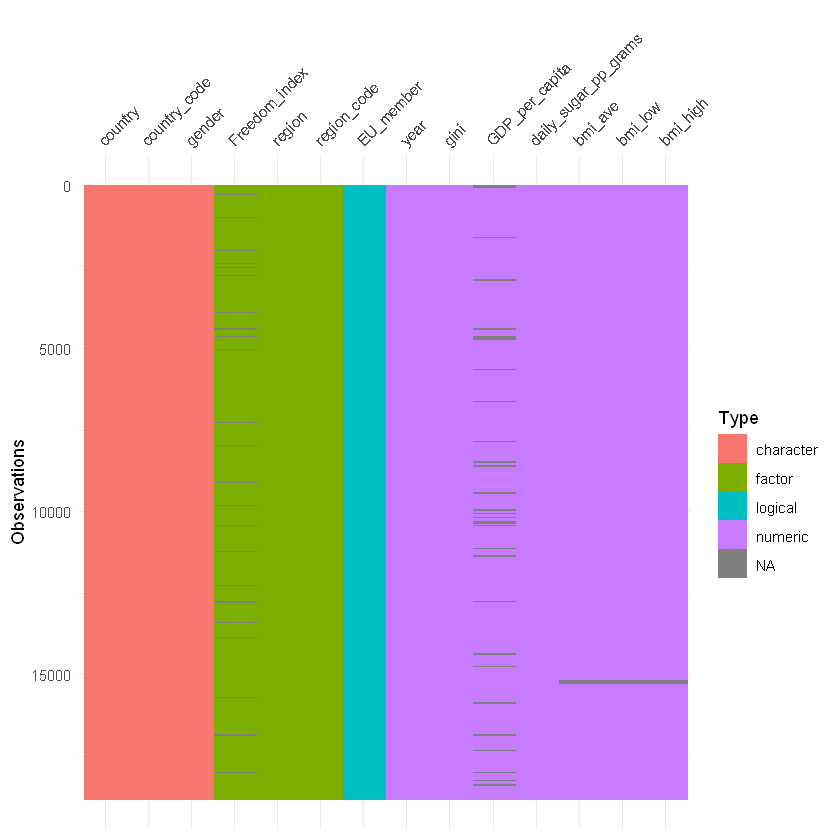

In [25]:
#check the results
dff %>%
    glimpse() %>%
    vis_dat() 

In [26]:
#write_xlsx(dff, 'dataframe.xlsx')

In [27]:
plot1 = dff %>% 
        filter(year == 1975) %>%
        ggplot(aes(
            x=gender,
            y=bmi_ave)) +
        geom_boxplot() +
        facet_wrap(~region) +
        theme_minimal() +
    labs(title = 'Comparing gender and BMI across regions in 1975',
         y = 'Average BMI')

Warning message:
"Removed 3 rows containing non-finite values (`stat_boxplot()`)."


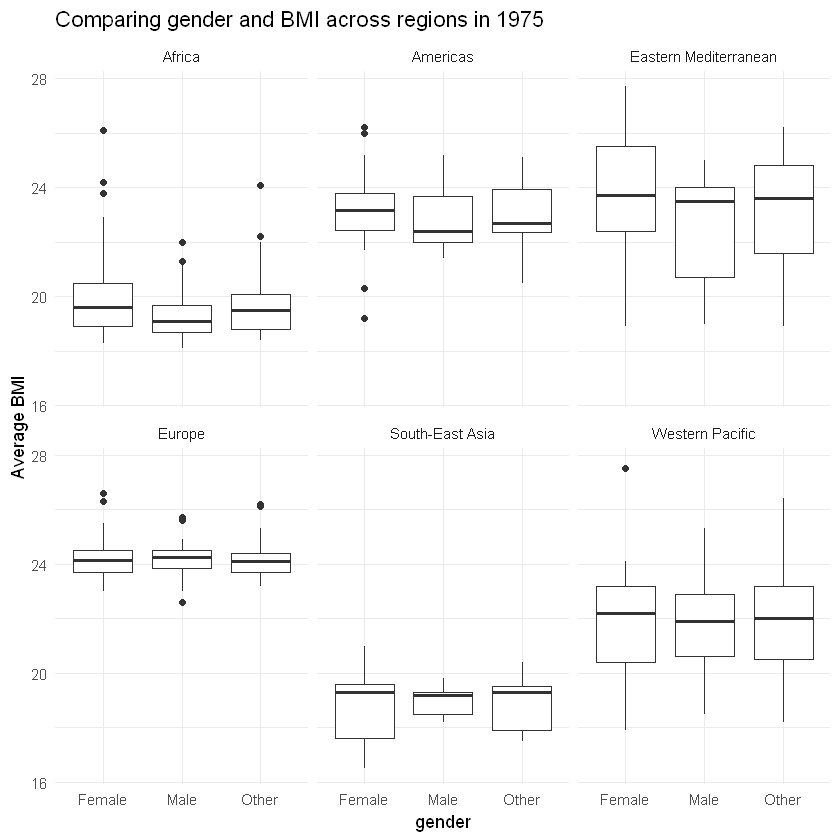

In [28]:
plot1 #higher gini values indicates more inequality

In [29]:
plot2 = dff %>% 
        filter(year == 2016) %>%
        ggplot(aes(
            x=Freedom_index,
            y=bmi_ave)) +
        geom_boxplot() +
        facet_wrap(~gender) +
    labs(title = '')

Warning message:
"Removed 3 rows containing non-finite values (`stat_boxplot()`)."


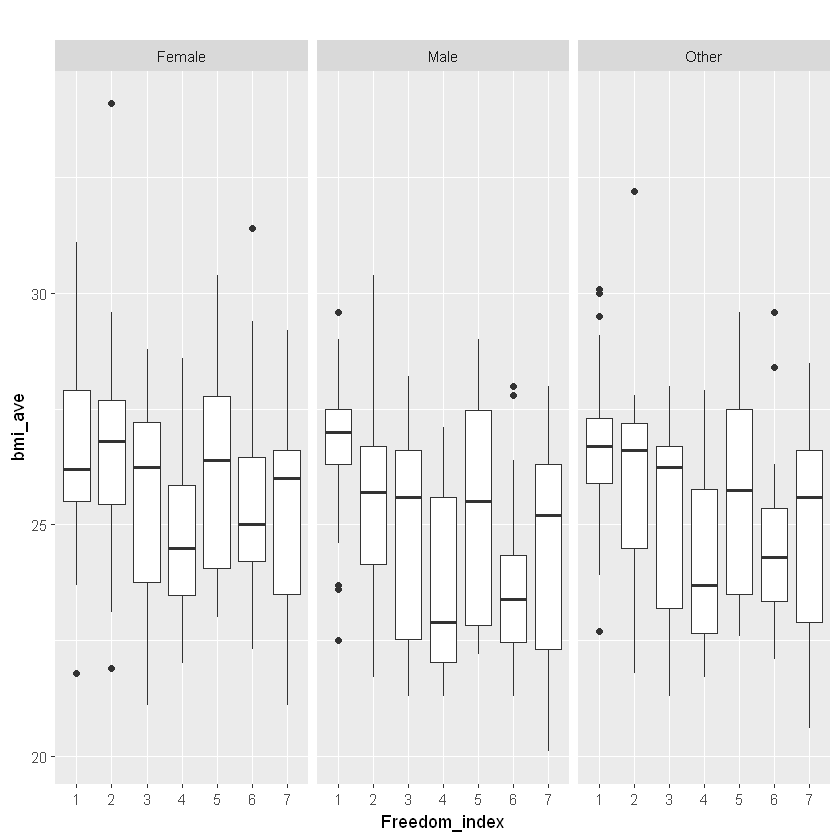

In [30]:
plot2

In [31]:
plot3 = dff %>% 
        ggplot(aes(
            x=year,
            y=bmi_ave)) +
        geom_bin_2d() +
        facet_wrap(~EU_member) +
    labs(title = '')

Warning message:
"Removed 126 rows containing non-finite values (`stat_bin2d()`)."


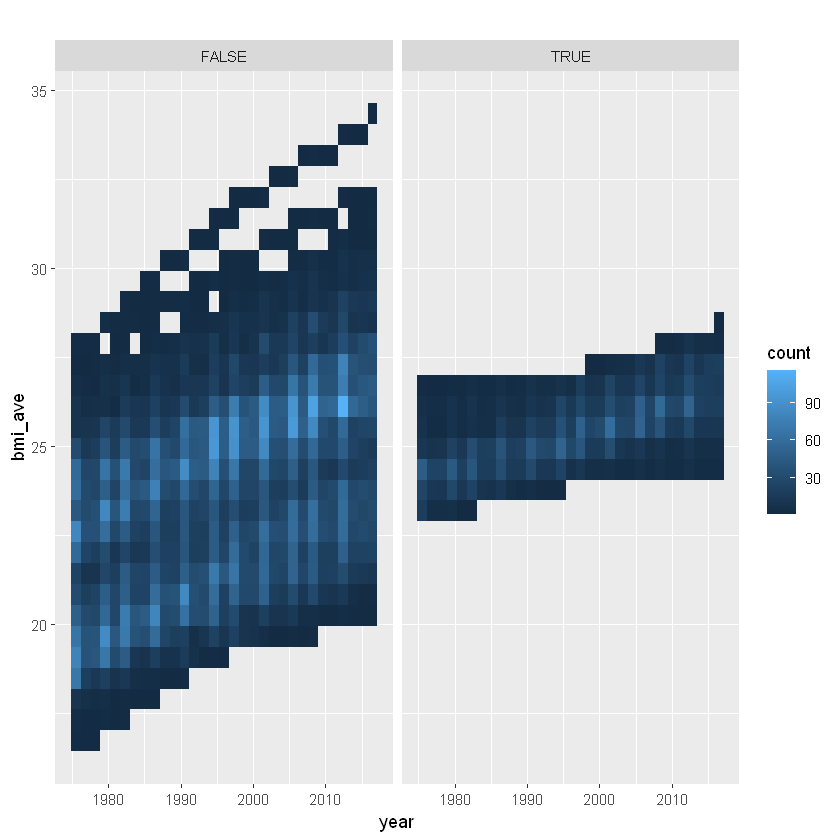

In [32]:
plot3

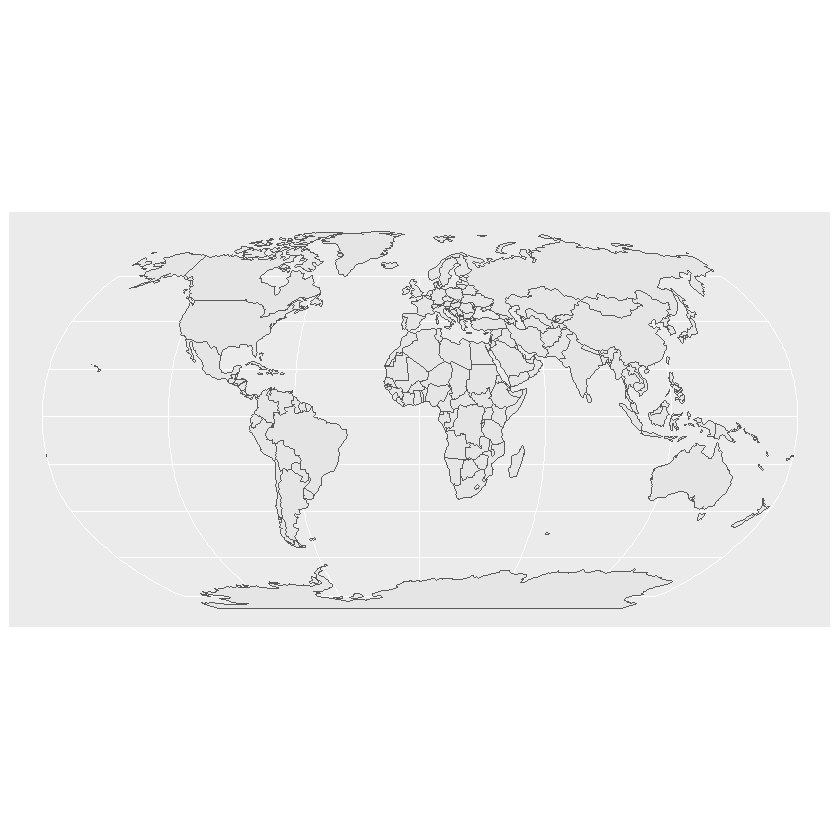

In [33]:
world <- ne_countries(scale = "small", returnclass = "sf")

world %>%
 st_transform(crs = "+proj=robin") %>%
  ggplot() +
  geom_sf()


In [34]:
data_with_iso <- dff %>%
  mutate(Iso3 = countrycode::countrycode(
    sourcevar = country, 
    origin = "country.name", 
    destination = "iso3c"))

In [35]:
dfmap <- world %>%
  select(geometry, iso_a3) %>%
  left_join(data_with_iso, by = c("iso_a3" = "country_code")) 

#countries_visited

In [36]:
sort(unique(dff$country))
sort(unique(dfmap$country))

[1] "Afghanistan"                      "Albania"                         
  [3] "Algeria"                          "Angola"                          
  [5] "Antigua and Barbuda"              "Argentina"                       
  [7] "Armenia"                          "Australia"                       
  [9] "Austria"                          "Azerbaijan"                      
 [11] "Bahamas"                          "Bangladesh"                      
 [13] "Barbados"                         "Belarus"                         
 [15] "Belgium"                          "Belize"                          
 [17] "Benin"                            "Bolivia, Plurinational State of" 
 [19] "Bosnia and Herzegovina"           "Botswana"                        
 [21] "Brazil"                           "Brunei Darussalam"               
 [23] "Bulgaria"                         "Burkina Faso"                    
 [25] "Cambodia"                         "Cameroon"                        
 [27] "Canada"                           "Cape Verde"                      
 [29] "Central African Republic"         "Chad"                            
 [31] "Chile"                            "China"                           
 [33] "Colombia"                         "Congo"                           
 [35] "Costa Rica"                       "Côte d'Ivoire"                   
 [37] "Croatia"                          "Cuba"                            
 [39] "Cyprus"                           "Czech Republic"                  
 [41] "Denmark"                          "Djibouti"                        
 [43] "Dominica"                         "Dominican Republic"              
 [45] "Ecuador"                          "Egypt"                           
 [47] "El Salvador"                      "Estonia"                         
 [49] "Ethiopia"                         "Fiji"                            
 [51] "Finland"                          "France"                          
 [53] "Gabon"                            "Gambia"                          
 [55] "Georgia"                          "Germany"                         
 [57] "Ghana"                            "Greece"                          
 [59] "Grenada"                          "Guatemala"                       
 [61] "Guinea"                           "Guinea-Bissau"                   
 [63] "Guyana"                           "Haiti"                           
 [65] "Honduras"                         "Hungary"                         
 [67] "Iceland"                          "India"                           
 [69] "Indonesia"                        "Iraq"                            
 [71] "Ireland"                          "Israel"                          
 [73] "Italy"                            "Jamaica"                         
 [75] "Japan"                            "Jordan"                          
 [77] "Kazakhstan"                       "Kenya"                           
 [79] "Kiribati"                         "Korea, Republic of"              
 [81] "Kuwait"                           "Lao People's Democratic Republic"
 [83] "Latvia"                           "Lebanon"                         
 [85] "Lesotho"                          "Liberia"                         
 [87] "Lithuania"                        "Luxembourg"                      
 [89] "Madagascar"                       "Malawi"                          
 [91] "Malaysia"                         "Maldives"                        
 [93] "Mali"                             "Malta"                           
 [95] "Mauritania"                       "Mauritius"                       
 [97] "Mexico"                           "Moldova, Republic of"            
 [99] "Mongolia"                         "Montenegro"                      
[101] "Morocco"                          "Mozambique"                      
[103] "Myanmar"                          "Namibia"                         
[105] "Nepal"                            "Netherla

[1] "Afghanistan"                      "Albania"                         
  [3] "Algeria"                          "Angola"                          
  [5] "Argentina"                        "Armenia"                         
  [7] "Australia"                        "Austria"                         
  [9] "Azerbaijan"                       "Bahamas"                         
 [11] "Bangladesh"                       "Belarus"                         
 [13] "Belgium"                          "Belize"                          
 [15] "Benin"                            "Bolivia, Plurinational State of" 
 [17] "Bosnia and Herzegovina"           "Botswana"                        
 [19] "Brazil"                           "Brunei Darussalam"               
 [21] "Bulgaria"                         "Burkina Faso"                    
 [23] "Cambodia"                         "Cameroon"                        
 [25] "Canada"                           "Central African Republic"        
 [27] "Chad"                             "Chile"                           
 [29] "China"                            "Colombia"                        
 [31] "Congo"                            "Costa Rica"                      
 [33] "Côte d'Ivoire"                    "Croatia"                         
 [35] "Cuba"                             "Cyprus"                          
 [37] "Czech Republic"                   "Denmark"                         
 [39] "Djibouti"                         "Dominican Republic"              
 [41] "Ecuador"                          "Egypt"                           
 [43] "El Salvador"                      "Estonia"                         
 [45] "Ethiopia"                         "Fiji"                            
 [47] "Finland"                          "Gabon"                           
 [49] "Gambia"                           "Georgia"                         
 [51] "Germany"                          "Ghana"                           
 [53] "Greece"                           "Guatemala"                       
 [55] "Guinea"                           "Guinea-Bissau"                   
 [57] "Guyana"                           "Haiti"                           
 [59] "Honduras"                         "Hungary"                         
 [61] "Iceland"                          "India"                           
 [63] "Indonesia"                        "Iraq"                            
 [65] "Ireland"                          "Israel"                          
 [67] "Italy"                            "Jamaica"                         
 [69] "Japan"                            "Jordan"                          
 [71] "Kazakhstan"                       "Kenya"                           
 [73] "Korea, Republic of"               "Kuwait"                          
 [75] "Lao People's Democratic Republic" "Latvia"                          
 [77] "Lebanon"                          "Lesotho"                         
 [79] "Liberia"                          "Lithuania"                       
 [81] "Luxembourg"                       "Madagascar"                      
 [83] "Malawi"                           "Malaysia"                        
 [85] "Mali"                             "Mauritania"                      
 [87] "Mexico"                           "Moldova, Republic of"            
 [89] "Mongolia"                         "Montenegro"                      
 [91] "Morocco"                          "Mozambique"                      
 [93] "Myanmar"                          "Namibia"                         
 [95] "Nepal"                            "Netherlands"                     
 [97] "New Zealand"                      "Nicaragua"                       
 [99] "Niger"                            "Nigeria"                         
[101] "Oman"                             "Pakistan"                        
[103] "Panama"                           "Paraguay"                        
[105] "Peru"                             "Philippi

In [37]:
colnames(dfmap)

[1] "iso_a3"               "year"                 "country"             
 [4] "Freedom_index"        "gini"                 "GDP_per_capita"      
 [7] "region"               "region_code"          "EU_member"           
[10] "gender"               "daily_sugar_pp_grams" "bmi_ave"             
[13] "bmi_low"              "bmi_high"             "Iso3"                
[16] "geometry"

In [38]:
world_plot = world %>%
  filter(admin != "Antarctica") %>%
  st_transform(crs = "+proj=robin") %>%
  ggplot() +
  geom_sf() +
  geom_sf(data = dfmap %>% filter(year==2016), aes(fill = daily_sugar_pp_grams)) +
  scale_fill_gradient(low='green', high = 'red', na.value = 'black') +
  theme_minimal() +

  theme(plot.title = element_text(face = "bold"),
        axis.text.x = element_blank()) +
  labs(title = "Average BMI by country",
       subtitle = 'need to fill in the missing values :)',
       x = NULL, y = NULL)

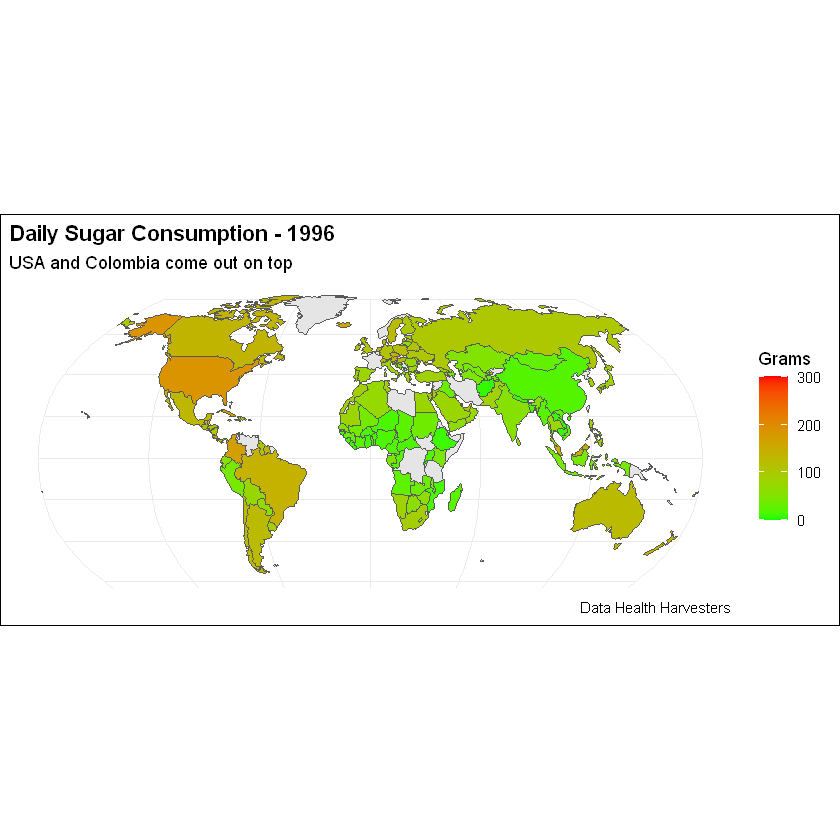

In [132]:
world_plot_sugar <- world %>%
  filter(admin != "Antarctica") %>%
  st_transform(crs = "+proj=robin") %>%
  ggplot() +
  geom_sf() +
  geom_sf(data = dfmap %>% 
          filter(year == 1996), 
          aes(fill = daily_sugar_pp_grams)) +
  scale_fill_gradient(limits = c(0, 300), 
                      low = 'green', 
                      high = 'red', 
                      na.value = 'gray') +
  theme_minimal() +
  theme(
    plot.title = element_text(face = "bold"),
    axis.text.x = element_blank(),
    plot.background = element_rect(fill = "white"),  # Set the background color for the entire chart area
    panel.background = element_blank()  # Remove the panel background
  ) +
  labs(title = "Daily Sugar Consumption - 1996",
       subtitle = 'USA and Colombia come out on top',
       x = NULL, y = NULL,
      caption = 'Data Health Harvesters',
      fill = 'Grams')

# Print and save the modified plot
print(world_plot_sugar)
#ggsave("world_plot_sugar_.png", plot = world_plot_sugar)


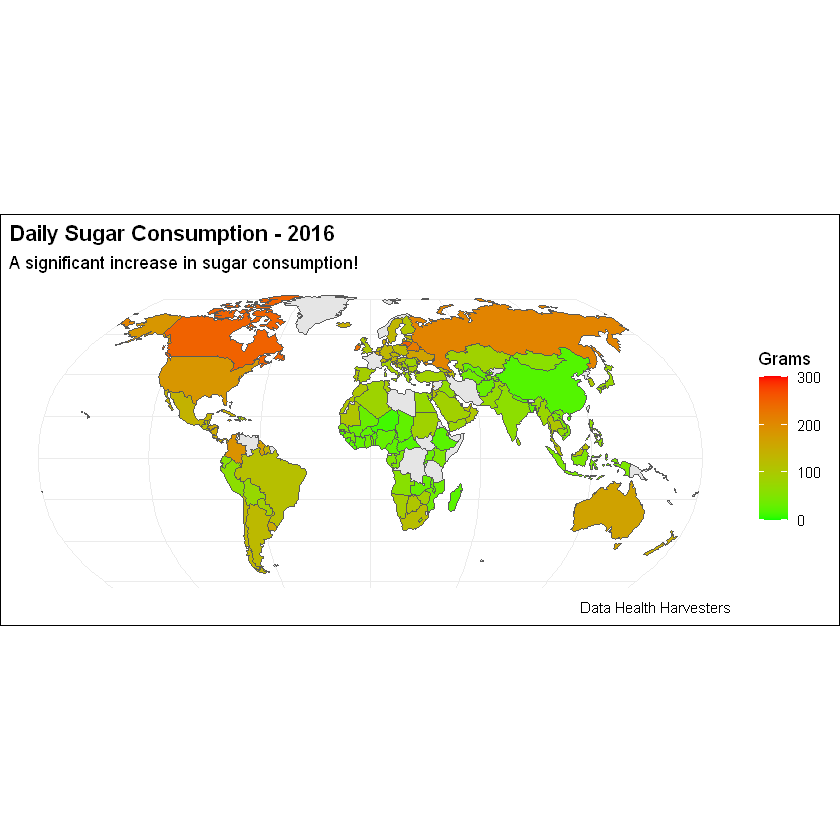

In [130]:
world_plot_sugar <- world %>%
  filter(admin != "Antarctica") %>%
  st_transform(crs = "+proj=robin") %>%
  ggplot() +
  geom_sf() +
  geom_sf(data = dfmap %>% 
          filter(year == 2016), 
          aes(fill = daily_sugar_pp_grams)) +
  scale_fill_gradient(limits = c(0, 300), 
                      low = 'green', 
                      high = 'red', 
                      na.value = 'gray') +
  theme_minimal() +
  theme(
    plot.title = element_text(face = "bold"),
    axis.text.x = element_blank(),
    plot.background = element_rect(fill = "white"),  # Set the background color for the entire chart area
    panel.background = element_blank()  # Remove the panel background
  ) +
  labs(title = "Daily Sugar Consumption - 2016",
       subtitle = 'A significant increase in sugar consumption!',
       x = NULL, y = NULL,
      caption = 'Data Health Harvesters',
      fill = 'Grams')

# Print and save the modified plot
print(world_plot_sugar)
#ggsave("world_plot_sugar_.png", plot = world_plot_sugar)


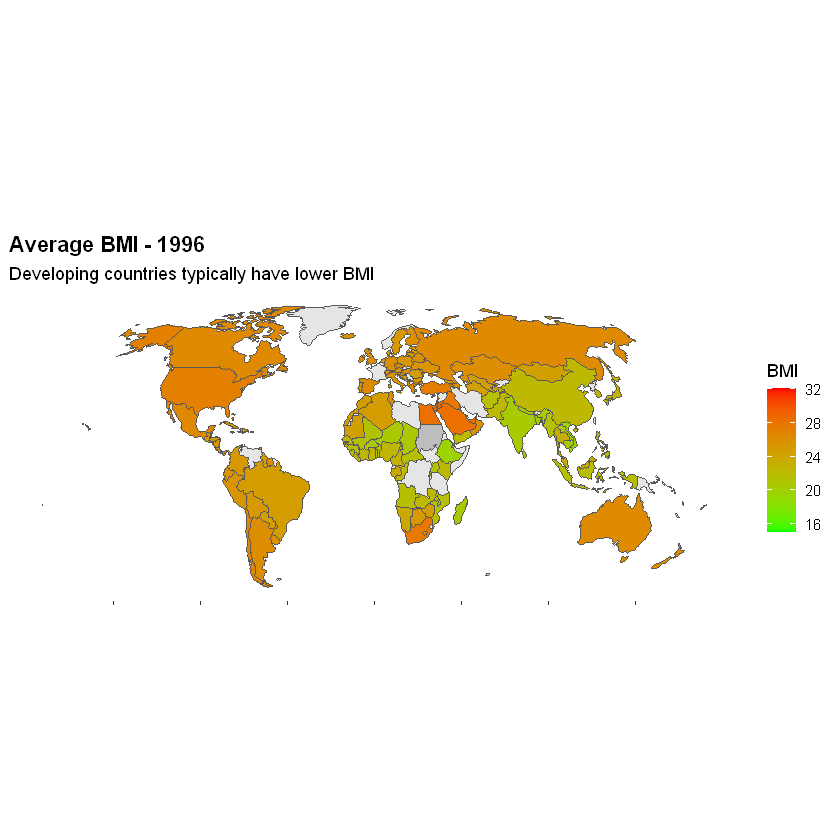

In [144]:
world_plot_bmi_1996 <- world %>%
  filter(admin != "Antarctica") %>%
  st_transform(crs = "+proj=robin") %>%
  ggplot() +
geom_sf() +
  geom_sf(data = dfmap %>% 
          filter(year == 1996), 
          aes(fill = bmi_ave)) +
  scale_fill_gradient(limits = c(15, 32), 
                      low = 'green', 
                      high = 'red', 
                      na.value = 'gray') +
  theme(
    plot.title = element_text(face = "bold"),
    axis.text.x = element_blank(),
    plot.background = element_rect(fill = "white"),  # Set the background color for the entire chart area
    panel.background = element_blank()  # Remove the panel background
  ) +
  labs(title = "Average BMI - 1996",
       subtitle = 'Developing countries typically have lower BMI',
       x = NULL, y = NULL,
      fill = 'BMI')

# Print and save the modified plot
print(world_plot_bmi_1996)
#ggsave("world_plot_bmi.png", plot = world_plot_bmi)


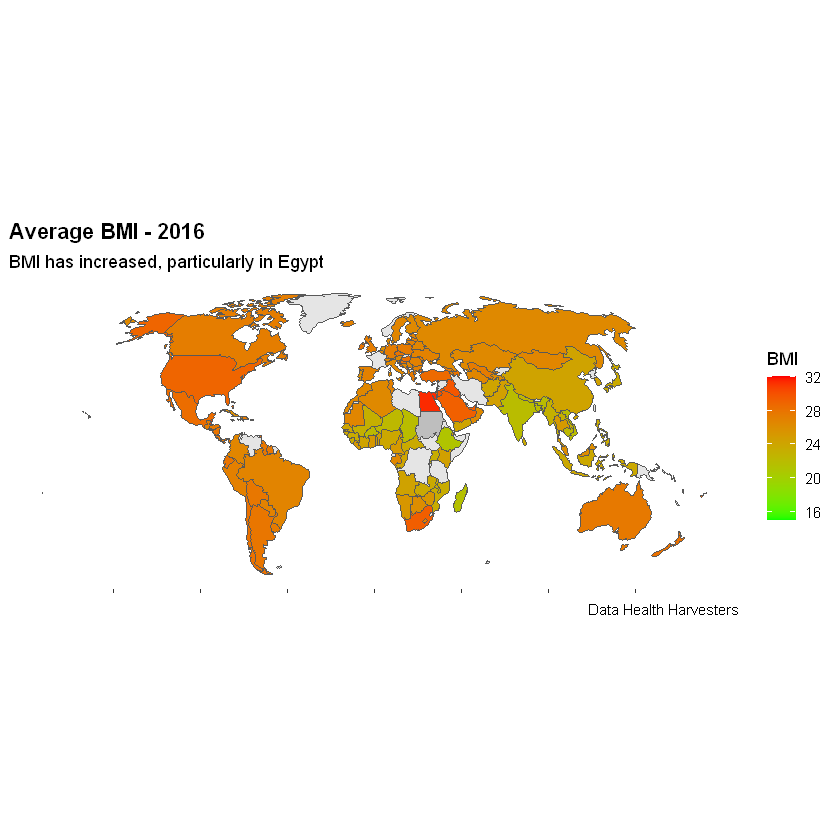

In [150]:
world_plot_bmi_2016 <- world %>%
  filter(admin != "Antarctica") %>%
  st_transform(crs = "+proj=robin") %>%
  ggplot() +
geom_sf() +
  geom_sf(data = dfmap %>% 
          filter(year == 2016), 
          aes(fill = bmi_ave)) +
  scale_fill_gradient(limits = c(15, 32), 
                      low = 'green', 
                      high = 'red', 
                      na.value = 'gray') +
  theme(
    plot.title = element_text(face = "bold"),
    axis.text.x = element_blank(),
    plot.background = element_rect(fill = "white"),  # Set the background color for the entire chart area
    panel.background = element_blank()  # Remove the panel background
  ) +
  labs(title = "Average BMI - 2016",
       subtitle = 'BMI has increased, particularly in Egypt',
       x = NULL, y = NULL,
      fill = 'BMI',
      caption = 'Data Health Harvesters')

# Print and save the modified plot
print(world_plot_bmi_2016)
#ggsave("world_plot_bmi.png", plot = world_plot_bmi)


In [ ]:
#ggsave("world_ploqqt.png", plot = world_plot, width = 6, height = 4, dpi = 300)

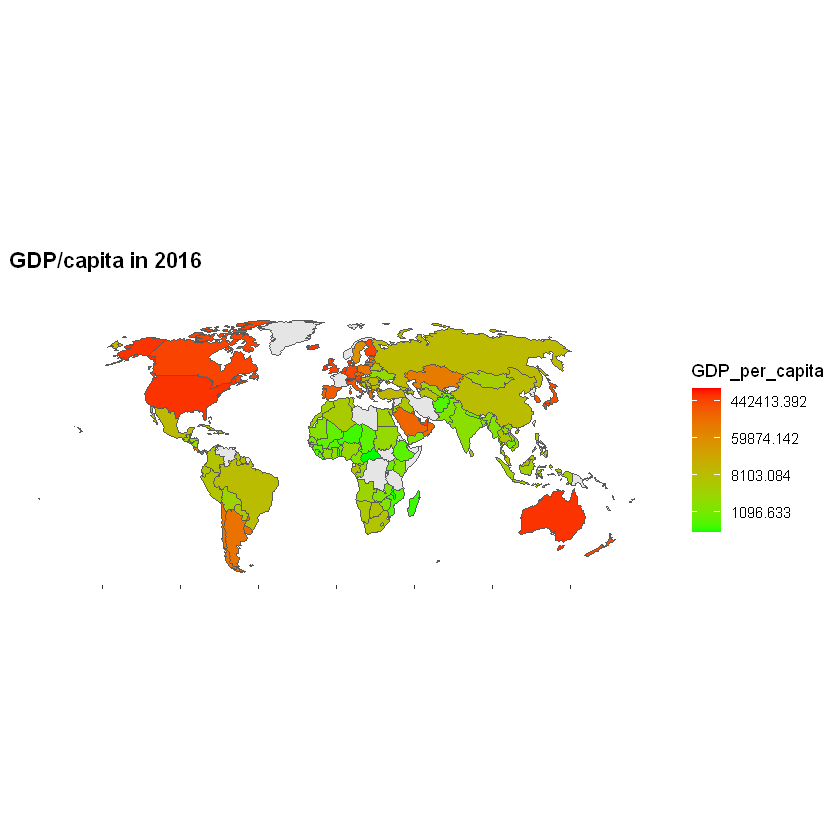

In [160]:
world_plot_sugar_ <- world %>%
  filter(admin != "Antarctica") %>%
  st_transform(crs = "+proj=robin") %>%
  ggplot() +
geom_sf() +
  geom_sf(data = dfmap %>% 
          filter(year == 2016) %>% 
          subset(Iso3 != 'FJI'), 
          aes(fill = GDP_per_capita)) +
  scale_fill_gradient(trans = 'log',
                      low = 'green', 
                      high = 'red', 
                      na.value = 'gray') +
  theme(
    plot.title = element_text(face = "bold"),
    axis.text.x = element_blank(),
    plot.background = element_rect(fill = "white"),  # Set the background color for the entire chart area
    panel.background = element_blank()  # Remove the panel background
  ) +
  labs(title = "GDP/capita in 2016",
       subtitle = '',
       x = NULL, y = NULL)

# Print and save the modified plot
print(world_plot_sugar_)
#ggsave("world_plot_bmi.png", plot = world_plot_bmi)
